<h1 style="color: #002c77; font-size: 40px"> DECISION TREE - BIKE RENTAL DATASET </h1>

- The main objective of this notebook is to predict the total number of bikes people rented in a given hour

<hr>

<h2> Header </h2>

### Load python libraries

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import datetime
import gc
import psutil
import random
from IPython.display import Markdown, display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
%matplotlib inline

### Change pandas visual options

In [2]:
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

height has been deprecated.



<hr>

<h2> Load raw dataset </h2>

In [3]:
rBike = pd.read_csv(r'bike_rental_hour.csv')

<hr>

<h2> Dataset analysis </h2>

### First 5 rows of the dataframe 

In [4]:
rBike.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Histogram of the total bike rented 

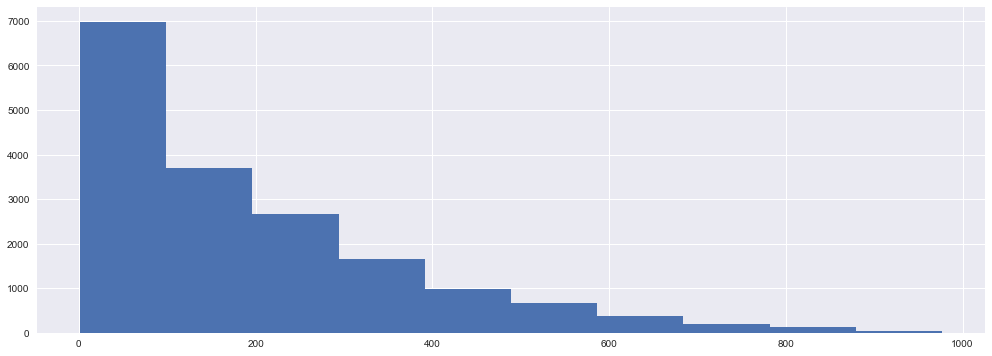

In [5]:
plt.figure(figsize=(17,6))
plt.hist(rBike['cnt']);

### Correlation of each column with the total number of bike rented 

In [6]:
rBike.corr()['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

<hr>

<h2> Data Manipulation </h2>

### Feature engineering 

In [7]:
## Bundle the hr column (which hour the bike was rented) into day-time periods (morning, afternoon, ...)
morning = ((rBike['hr']>=6)&(rBike['hr']<12))
afternoon = ((rBike['hr']>=12)&(rBike['hr']<18))
evening = ((rBike['hr']>=18)&(rBike['hr']<=24))
night = ((rBike['hr']>=0)&(rBike['hr']<6))

rBike['time_label'] = np.where(morning, 1,
                               np.where(afternoon, 2,
                                        np.where(evening, 3,
                                                 np.where(night, 4,
                                                          False))))

<hr>

<h2> Model Building </h2>

### Definition of the error metric 

In [80]:
## Define the error metric
error_metric = 'MSE'

### Train Test Split 

In [87]:
X_train, X_test, y_train, y_test = train_test_split(rBike, rBike['cnt'], test_size=0.2, random_state=1)

### Feature selection 

Note: The casual and registered columns should not be used since they are added together to get the cnt column (our target)

In [88]:
feature_cols = ['season', 'time_label', 'mnth', 'holiday', 'weekday', 'temp',
                'atemp', 'hum', 'windspeed']

## Select features dataset and target dataset
X_train = X_train[feature_cols]
X_test = X_test[feature_cols]

### Linear Regression 

In [89]:
## Instantiate the linear regression model
ln = LinearRegression()

## Fit the model in the training dataset
ln.fit(X_train, y_train)

## Make predictions in the test set
predictions = ln.predict(X_test)

## Calculate the error
if error_metric=='MAE':
    error = mean_absolute_error(y_test, predictions)
elif error_metric=='MSE':
    error = mean_squared_error(y_test, predictions)
    
print(error_metric + ':', error)

MSE: 21395.215154810634


- MSE is very high. This is due to the fact that the data has a few extremely high rental counts (outliers), which were shown in the histogram plotted above
- MAE is really low (close to 100) which supports our point that the MSE is high due to outliers

### Decision Trees 

The below code gives the output for several hyperparameters tuning in the Decision Tree model

In [93]:
## max depth to test
maximum_depth = [i for i in range(2,11)]
samples_leaf = [i for i in range(1,51)]


minimum_error = 10**10
for depth in maximum_depth:
    for samples in samples_leaf:
        ## Instantiate the decision tree
        dt = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=samples)

        ## Fit the model in the training dataset
        dt.fit(X_train, y_train)

        ## Make predictions in the test set
        predictions = dt.predict(X_test)

        ## Calculate the error
        if error_metric=='MAE':
            error = mean_absolute_error(y_test, predictions)
        elif error_metric=='MSE':
            error = mean_squared_error(y_test, predictions)
            
        if error < minimum_error:
            minimum_error = error
            best_depth = str(depth)
            best_samples_leaf = str(samples)
            
print('max_depth=' + best_depth + '|' + 'min_samples_leaf=' + best_samples_leaf + '-' + error_metric + ':', minimum_error)

max_depth=10|min_samples_leaf=12-MSE: 15580.9284676063


- The lower MSE is accomplished when max_depth is set to 10 and min_samples_leaf is set to 12
- The Decision Tree model has a lower MSE when compared to the Linear Regression model. This means that the model has a better prediction when we take into account nonlinear predictors

### Random Forest 

In [111]:
## max depth to test
maximum_depth = [i for i in range(2,11)]
samples_leaf = [i for i in range(1,31)]
n_estimators = [i for i in range(100, 200, 50)]

total_combinations = len(maximum_depth)*len(samples_leaf)*len(n_estimators)

i= 0 
minimum_error = 10**10
for depth in maximum_depth:
    for samples in samples_leaf:
        for estimator in n_estimators:
            i += 1
            ## Instantiate the decision tree
            rf = RandomForestRegressor(max_depth=depth, min_samples_leaf=samples, n_estimators=estimator)

            ## Fit the model in the training dataset
            rf.fit(X_train, y_train)

            ## Make predictions in the test set
            predictions = rf.predict(X_test)

            ## Calculate the error
            if error_metric=='MAE':
                error = mean_absolute_error(y_test, predictions)
            elif error_metric=='MSE':
                error = mean_squared_error(y_test, predictions)

            if error < minimum_error:
                minimum_error = error
                best_depth = str(depth)
                best_samples_leaf = str(samples)
                best_estimator = str(estimator)
            print(i, 'scenario out of ' + str(total_combinations), end='\r')
            
print('max_depth=' + best_depth + '|' + 'min_samples_leaf=' + best_samples_leaf + 'n_estimators=' + best_estimator +
      '-' + error_metric + ':', minimum_error)

max_depth=10|min_samples_leaf=2n_estimators=150-MSE: 14110.700697304328


- Decision tree are prone to overfitting. We tried to reduce the risk of overfitting by limiting the maximum depth of the tree as well as the minimum samples in a leaf
- However, as the error in the Random Forest model shows, there were still sources of overfitting in our Decision tree model
- Random Forest models, on the other hand, are resistant to overfitting since they are an ensemble algorithm (combines the result of multiple decision trees)

<hr>